# Import libraries

In [5]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import pycountry
import re

from tqdm import tqdm
tqdm.pandas()

from strsimpy.levenshtein import Levenshtein
from strsimpy.normalized_levenshtein import NormalizedLevenshtein

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import seaborn as sns
sns.set()
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

from scipy.sparse import csr_matrix

import lightgbm as lgb
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score

from sklearn.metrics import classification_report, f1_score


# import googletrans
# from googletrans import Translator
import cyrtranslit

# Functions

In [6]:
# convert text to lowercase
def lower_str(data,column):
    data[column] = data[column].str.lower()

In [7]:
# statistic table for analyse float values (it needs to make histogramms and boxplots)
def data_statistics(data,analyse,title_print):

    data0 = data[data['target']==0][analyse]
    data1 = data[data['target']==1][analyse]

    data_describe = pd.DataFrame()
    data_describe['target_0'] = data0.describe()
    data_describe['target_1'] = data1.describe()
    data_describe = data_describe.T
    
    if title_print == 'yes':
        print ('\033[1m' + 'Дополнительные статистики по признаку',analyse,'\033[m') 
    elif title_print == 'no':
        None
    
    return data_describe

In [8]:
# histogramms for float values
def hist_fz(data,data_describe,analyse,size):
    print ()
    print ('\033[1m' + 'Information about',analyse,'\033[m')
    print ()
    
    data_0 = data[data['target'] == 0][analyse]
    data_1 = data[data['target'] == 1][analyse]
    
    min_data = data_describe['min'].min()
    max_data = data_describe['max'].max()
    
    data0_mean = data_describe.loc['target_0']['mean']
    data0_median = data_describe.loc['target_0']['50%']
    data0_min = data_describe.loc['target_0']['min']
    data0_max = data_describe.loc['target_0']['max']
    data0_count = data_describe.loc['target_0']['count']
    
    
    data1_mean = data_describe.loc['target_1']['mean']
    data1_median = data_describe.loc['target_1']['50%'] 
    data1_min = data_describe.loc['target_1']['min']
    data1_max = data_describe.loc['target_1']['max']
    data1_count = data_describe.loc['target_1']['count']
    
    
    print ('\033[4m' + 'Analyse'+ '\033[m','No duplicates')
    
    figure(figsize=size)
    sns.distplot(data_0,color='darkgreen',kde = False)
    
    plt.scatter(data0_mean,0,s=200,marker='o',c='dimgray',label='Mean')
    plt.scatter(data0_median,0,s=250,marker='|',c='black',label='Median')
    plt.legend(scatterpoints=1,
               loc='upper right',
               ncol=3,
               fontsize=16)
    plt.xlim(min_data, max_data)
    plt.show()
    print ('Quantity:', data0_count,
           '         Min:', round(data0_min,2),
           '         Max:', round(data0_max,2),
           '         Mean:', round(data0_mean,2),
           '         Median:', round(data0_median,2))
    
    print ()
    print ('\033[4m' + 'Analyse'+ '\033[m','Duplicates')
    
    figure(figsize=size)
    sns.distplot(data_1,color='darkred',kde = False)
    plt.scatter(data1_mean,0,s=200,marker='o',c='dimgray',label='Mean')
    plt.scatter(data1_median,0,s=250,marker='|',c='black',label='Median')
    plt.legend(scatterpoints=1,
               loc='upper right',
               ncol=3,
               fontsize=16)
    plt.xlim(min_data, max_data)
    plt.show()
    print ('Quantity:', data_1.count(),
           '         Min:', round(data1_min,2),
           '         Max:', round(data1_max,2),
           '         Mean:', round(data1_mean,2),
           '         Median:', round(data1_median,2))

In [9]:
# draw boxplot
def boxplot(data,analyse,size):
    print ('\033[4m' + 'Analyse'+ '\033[m','All pairs')
    
    data_0 = data[data['target'] == 0][analyse]
    data_1 = data[data['target'] == 1][analyse]
    
    figure(figsize=size)
    sns.boxplot(x=analyse,y='target',data=data,orient='h',
                showmeans=True,                
                meanprops={"marker":"o",
                           "markerfacecolor":"dimgray", 
                           "markeredgecolor":"black",
                          "markersize":"14"},
               palette=['palegreen', 'salmon'])
    plt.ylabel('target', size=14)
    plt.xlabel(analyse, size=14)
    plt.show()

In [10]:
# draw graph for analyse two choosing features for predict traget label
def two_features(data,analyse1,analyse2,size):
    fig = plt.subplots(figsize=size)
    
    x0 = data[data['target']==0][analyse1]
    y0 = data[data['target']==0][analyse2]
    x1 = data[data['target']==1][analyse1]
    y1 = data[data['target']==1][analyse2]
    
    plt.scatter(x0,y0,c='green',marker='.')
    plt.scatter(x1,y1,c='black',marker='+')
    plt.xlabel(analyse1)
    plt.ylabel(analyse2)
    title = [analyse1,analyse2]
    plt.title(title)
    plt.show()

In [11]:
def contingency_table(X,features,probability_level,tridx,cvidx,model):
    tr_predict_proba = model.predict_proba(X.iloc[tridx][features].values)
    cv_predict_proba = model.predict_proba(X.iloc[cvidx][features].values)

    tr_predict_target = (tr_predict_proba[:, 1] > probability_level).astype(np.int)
    cv_predict_target = (cv_predict_proba[:, 1] > probability_level).astype(np.int)

    X_tr = X.iloc[tridx]
    X_cv = X.iloc[cvidx]

    X_tr['predict_proba'] = tr_predict_proba[:,1]
    X_cv['predict_proba'] = cv_predict_proba[:,1]

    X_tr['predict_target'] = tr_predict_target
    X_cv['predict_target'] = cv_predict_target

    # make true positive column
    data = pd.DataFrame(X_tr[X_tr['target']==1][X_tr['predict_target']==1]['pair_id'])
    data['True_Positive'] = 1
    X_tr = X_tr.merge(data,on='pair_id',how='left')

    data = pd.DataFrame(X_cv[X_cv['target']==1][X_cv['predict_target']==1]['pair_id'])
    data['True_Positive'] = 1
    X_cv = X_cv.merge(data,on='pair_id',how='left')

    # make false positive column
    data = pd.DataFrame(X_tr[X_tr['target']==0][X_tr['predict_target']==1]['pair_id'])
    data['False_Positive'] = 1
    X_tr = X_tr.merge(data,on='pair_id',how='left')

    data = pd.DataFrame(X_cv[X_cv['target']==0][X_cv['predict_target']==1]['pair_id'])
    data['False_Positive'] = 1
    X_cv = X_cv.merge(data,on='pair_id',how='left')

    # make true negative column
    data = pd.DataFrame(X_tr[X_tr['target']==0][X_tr['predict_target']==0]['pair_id'])
    data['True_Negative'] = 1
    X_tr = X_tr.merge(data,on='pair_id',how='left')

    data = pd.DataFrame(X_cv[X_cv['target']==0][X_cv['predict_target']==0]['pair_id'])
    data['True_Negative'] = 1
    X_cv = X_cv.merge(data,on='pair_id',how='left')

    # make false negative column
    data = pd.DataFrame(X_tr[X_tr['target']==1][X_tr['predict_target']==0]['pair_id'])
    data['False_Negative'] = 1
    X_tr = X_tr.merge(data,on='pair_id',how='left')

    data = pd.DataFrame(X_cv[X_cv['target']==1][X_cv['predict_target']==0]['pair_id'])
    data['False_Negative'] = 1
    X_cv = X_cv.merge(data,on='pair_id',how='left')
    
    return X_tr,X_cv

In [12]:
def matrix_confusion(X):

    list_matrix = ['True_Positive','False_Positive','True_Negative','False_Negative']

    tr_pos = X[list_matrix].sum().loc['True_Positive']
    f_pos = X[list_matrix].sum().loc['False_Positive']
    tr_neg = X[list_matrix].sum().loc['True_Negative']
    f_neg = X[list_matrix].sum().loc['False_Negative']
    matrix_confusion = pd.DataFrame()
    matrix_confusion['0_algorythm'] = np.array([tr_neg,f_neg]).T
    matrix_confusion['1_algorythm'] = np.array([f_pos,tr_pos]).T
    matrix_confusion = matrix_confusion.rename(index={0: '0_target', 1: '1_target'})
    
    return matrix_confusion

In [13]:
def report_score(tr_matrix_confusion,
                 cv_matrix_confusion,
                 data,tridx,cvidx,
                 X_tr,X_cv):
    # print some imporatant information
    print ('\033[1m'+'Matrix confusion on train data'+'\033[m')
    display(tr_matrix_confusion)
    print ()
    print(classification_report(data.iloc[tridx]["target"].values, X_tr['predict_target']))
    print ('******************************************************')
    print ()
    print ()
    print ('\033[1m'+'Matrix confusion on test(cv) data'+'\033[m')
    display(cv_matrix_confusion)
    print ()
    print(classification_report(data.iloc[cvidx]["target"].values, X_cv['predict_target']))
    print ('******************************************************')

In [14]:
def table_gain_coef(model,features,start,stop):
    
    data_gain = pd.DataFrame()
    data_gain['Features'] = features
    data_gain['Gain'] = model.booster_.feature_importance(importance_type='gain')
    return data_gain.sort_values('Gain', ascending=False)[start:stop]

In [15]:
def gain_hist(df,size,start,stop):
    fig, ax = plt.subplots(figsize=(size))
    x = (df.sort_values('Gain', ascending=False)['Features'][start:stop])
    y = (df.sort_values('Gain', ascending=False)['Gain'][start:stop])
    plt.bar(x,y)
    plt.xlabel('Features')
    plt.ylabel('Gain')
    plt.xticks(rotation=90)
    plt.show()

In [16]:
def compair_metrics(data):
    duplicate_count = []
    duplicate_sum = []
    for i in range(len(data)):
        count=len(data[i])
        duplicate_count.append(count)
        if count <= 0:
            duplicate_sum.append(0)
        elif count > 0:
            temp_sum = 0
            for j in range(len(data[i])):
                temp_sum +=len(data[i][j])
            duplicate_sum.append(temp_sum)

    return duplicate_count,duplicate_sum    

In [17]:
def transliterate(data):
    text_transliterate = []
    for i in range(data.shape[0]):
        temp_list = list(data[i:i+1])
        temp_str = ''.join(temp_list)
        result = cyrtranslit.to_latin(temp_str,'ru')
        text_transliterate.append(result)
    return text_transliterate

In [18]:
def rename_agg_columns(id_client,data,rename):
    columns = [id_client]
    for lev_0 in data.columns.levels[0]:
        if lev_0 != id_client:
            for lev_1 in data.columns.levels[1][:-1]:
                columns.append(rename % (lev_0, lev_1))
    data.columns = columns
    return data

In [19]:
def dist_name_to_top_list_view(data,column1,column2,list_top_companies):
    id_pair = []
    r1 = []
    r2 = []
    words1 = []
    words2 = []
    top_words = []

    for n in range(0, data.shape[0], 1):
        for line1 in data[column1][n:n+1]:
            line1 = line1.split()
            for word1 in line1:
                if len(word1) >=3:
                    for top_word in list_top_companies:
                        dist1 = levenshtein.distance(word1, top_word)
                        ratio = max(dist1/float(len(top_word)),dist1/float(len(word1)))
                        if ratio <= 0.4:
                            ratio1 = ratio
                            break
                    if ratio <= 0.4:
                        for line2 in data[column2][n:n+1]:
                            line2 = line2.split()
                            for word2 in line2:
                                dist2 = levenshtein.distance(word2, top_word)
                                ratio = max(dist2/float(len(top_word)),dist2/float(len(word2)))
                                if ratio <= 0.4:
                                    ratio2 = ratio
                                    id_pair.append(int(data['pair_id'][n:n+1].values))
                                    r1.append(ratio1)
                                    r2.append(ratio2)
                                    break

    df = pd.DataFrame()
    df['pair_id'] = id_pair
    df['levenstein_dist_w1_top_w'] = dist1
    df['levenstein_dist_w2_top_w'] = dist2
    df['length_w1_top_w'] = len(word1)
    df['length_w2_top_w'] = len(word2)
    df['length_top_w'] = len(top_word)
    df['ratio_dist_w1_to_top_w'] = r1
    df['ratio_dist_w2_to_top_w'] = r2
    feature = df.groupby(['pair_id']).agg([min]).reset_index()
    feature = rename_agg_columns(id_client='pair_id',data=feature,rename='%s_%s')

    data = data.merge(feature,on='pair_id',how='left')
    display(data)
    print ('Words:', word1,word2,top_word)
    print ('Levenstein distance:',dist1,dist2)
    print ('Length of word:',len(word1),len(word2),len(top_word))
    print ('Ratio (distance/length word):',ratio1,ratio2)

In [20]:
def dist_name_to_top_list_make(data,column1,column2,list_top_companies):
    id_pair = []
    r1 = []
    r2 = []
    dist_w1 = []
    dist_w2 = []
    length_w1 = []
    length_w2 = []
    length_top_w = []

    for n in range(0, data.shape[0], 1):
        for line1 in data[column1][n:n+1]:
            line1 = line1.split()
            for word1 in line1:
                if len(word1) >=3:
                    for top_word in list_top_companies:
                        dist1 = levenshtein.distance(word1, top_word)
                        ratio = max(dist1/float(len(top_word)),dist1/float(len(word1)))
                        if ratio <= 0.4:
                            ratio1 = ratio
                            break
                    if ratio <= 0.4:
                        for line2 in data[column2][n:n+1]:
                            line2 = line2.split()
                            for word2 in line2:
                                dist2 = levenshtein.distance(word2, top_word)
                                ratio = max(dist2/float(len(top_word)),dist2/float(len(word2)))
                                if ratio <= 0.4:
                                    ratio2 = ratio
                                    id_pair.append(int(data['pair_id'][n:n+1].values))
                                    r1.append(ratio1)
                                    r2.append(ratio2)
                                    dist_w1.append(dist1)
                                    dist_w2.append(dist2)
                                    length_w1.append(float(len(word1)))
                                    length_w2.append(float(len(word2)))
                                    length_top_w.append(float(len(top_word)))
                                    break

    df = pd.DataFrame()
    df['pair_id'] = id_pair
    df['levenstein_dist_w1_top_w'] = dist_w1
    df['levenstein_dist_w2_top_w'] = dist_w2
    df['length_w1_top_w'] = length_w1
    df['length_w2_top_w'] = length_w2
    df['length_top_w'] = length_top_w
    df['ratio_dist_w1_to_top_w'] = r1
    df['ratio_dist_w2_to_top_w'] = r2
    feature = df.groupby(['pair_id']).agg([min]).reset_index()
    feature = rename_agg_columns(id_client='pair_id',data=feature,rename='%s_%s')

    data = data.merge(feature,on='pair_id',how='left')
    return data

# Download data

In [21]:
# DOWNLOAD DATA
text_train = pd.read_csv('train.csv')
text_test = pd.read_csv('test.csv')

In [22]:
# RENAME DATA
text_train = text_train.rename(columns={"is_duplicate": "target"})

In [23]:
# ANALYSE BALANCE OF DATA
target_1 = text_train[text_train['target']==1]['target'].count()
target_0 = text_train[text_train['target']==0]['target'].count()

print ('There are', target_1, 'objects with target 1')
print ('There are', target_0, 'objects with target 0')
print ('Balance is', round(100*target_1/target_0,2),'%')

There are 3658 objects with target 1
There are 494161 objects with target 0
Balance is 0.74 %


# Baseline data

In [24]:
baseline_train = text_train.copy()
baseline_test = text_test.copy()

In [25]:
# convert text to lowercase
columns = ['name_1','name_2']
for column in columns:
    lower_str(baseline_train,column)
for column in columns:
    lower_str(baseline_test,column)

In [26]:
# drop any names of countries
countries = [country.name.lower() for country in pycountry.countries]
for country in tqdm(countries):
    baseline_train.replace(re.compile(country), "", inplace=True)
    baseline_test.replace(re.compile(country), "", inplace=True)

100%|██████████| 249/249 [07:43<00:00,  1.86s/it]


In [27]:
# drop punctuation marks
baseline_train.replace(re.compile(r"\s+\(.*\)"), "", inplace=True)
baseline_test.replace(re.compile(r"\s+\(.*\)"), "", inplace=True)

baseline_train.replace(re.compile(r"[^\w\s]"), "", inplace=True)
baseline_test.replace(re.compile(r"[^\w\s]"), "", inplace=True)

In [28]:
# drop some stop-words
drop_list = ["ltd.", "co.", "inc.", "b.v.", "s.c.r.l.", "gmbh", "pvt.",
             
             'retail','usa','asia','ceska republika','limited','tradig','llc','group',
             'international','plc','retail','tire','mills','chemical','korea','brasil',
             'holding','vietnam','tyre','venezuela','polska','americas','industrial','taiwan',
             'europe','america','north','czech republic','retailers','retails',
            
            'mexicana','corporation','corp','ltd','co','toronto','nederland','shanghai','gmb','pacific',
            'industries','industrias',
            
            'inc', 'ltda', 'ооо', 'зао', 'оао', 'пао', 'ceska republika', 'ltda', 
            'sibur', 'enterprises', 'electronics', 'products', 'distribution', 'logistics', 'development',
            'technologies', 'pvt', 'technologies', 'comercio', 'industria', 'trading', 'internacionais', 
            'bank', 'sports',
            
            'express','east', 'west', 'south', 'north', 'factory', 'transportes', 'trade', 'banco',
            'management', 'engineering', 'investments', 'enterprise', 'city', 'national', 'express', 'tech', 
            'auto', 'transporte', 'technology', 'and', 'central', 'american',
            
            'logistica','global','exportacao', 'ceska republika', 'vancouver', 'deutschland',
            
            'sro','rus','chemicals','private','distributors','tyres','industry','services','italia','beijing',
            
            'рус','company','the','und']

baseline_train['name_1_non_stop_words'] =\
    baseline_train['name_1'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (drop_list)]))
baseline_train['name_2_non_stop_words'] =\
    baseline_train['name_2'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (drop_list)]))

baseline_test['name_1_non_stop_words'] =\
    baseline_test['name_1'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (drop_list)]))
baseline_test['name_2_non_stop_words'] =\
    baseline_test['name_2'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (drop_list)]))

In [29]:
# baseline_train[baseline_train.name_1.str.contains("vancouver")]

In [30]:
# transliteration to latin
baseline_train['name_1_transliterated'] = transliterate(baseline_train['name_1_non_stop_words'])
baseline_train['name_2_transliterated'] = transliterate(baseline_train['name_2_non_stop_words'])
baseline_test['name_1_transliterated'] = transliterate(baseline_test['name_1_non_stop_words'])
baseline_test['name_2_transliterated'] = transliterate(baseline_test['name_2_non_stop_words'])

In [31]:
# pair_id = 353150
# baseline_train[baseline_train['pair_id']==353150]

In [32]:
# drop top 50 common words (NAME 1 & NAME 2) exept names of top companies

# first: make dictionary of frequency every word
list_words = baseline_train['name_1_transliterated'].to_string(index=False).split() +\
                baseline_train['name_2_transliterated'].to_string(index=False).split()
freq_words = {}
for w in list_words:
    freq_words[w] = freq_words.get(w, 0) + 1
    
# # second: make data frame
df_freq = pd.DataFrame.from_dict(freq_words,orient='index').reset_index()
df_freq.columns = ['word','frequency']
df_freq_agg = df_freq.groupby(['word']).agg([sum]).reset_index()
df_freq_agg = rename_agg_columns(id_client='word',data=df_freq_agg,rename='%s_%s')
df_freq_agg = df_freq_agg.sort_values(by=['frequency_sum'], ascending=False)
drop_list = list(df_freq_agg[0:50]['word'].to_string(index=False).split())

# # check list of top 50 common words
# print (drop_list)
 
# drop the top 50 words
baseline_train['name_1_finish'] =\
    baseline_train['name_1_transliterated'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (drop_list)]))
baseline_train['name_2_finish'] =\
    baseline_train['name_2_transliterated'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (drop_list)]))

baseline_test['name_1_finish'] =\
    baseline_test['name_1_transliterated'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (drop_list)]))
baseline_test['name_2_finish'] =\
    baseline_test['name_2_transliterated'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (drop_list)]))

In [33]:
# # fix the top 50 words
# drop_list = ['srl', 'sa', 'al', 'k', 'do', 'rl', 'shenzhen', 'j', 'as', 'de', 'mfg', 'h', 
# 'dongguan', 'sdn', 'polymers', 'e', 'automotive', 'of', 'sas', 'guangzhou', 'ram', 'pt', 'rubber', 
# 'c', 'y', 'r', 'p', 'cv', 'qingdao', 'l', 'service', 'materials', 'exp', 'imp', 'textile', 'sp', 'd',
# 'b', 'ag', 've', 's', 'a', 'itc', 'bhd', 'v', 'n', 'plastic', 'solutions', 'general', 'plastics']

In [34]:
# baseline_train[baseline_train.name_1_finish.str.contains("logistic")]

# Features

In [35]:
# create feature with LEVENSTAIN DISTANCE
levenshtein = Levenshtein()
column_1 = 'name_1_finish'
column_2 = 'name_2_finish'

baseline_train["levenstein"] = baseline_train.progress_apply(
    lambda r: levenshtein.distance(r[column_1], r[column_2]), axis=1)
baseline_test["levenstein"] = baseline_test.progress_apply(
    lambda r: levenshtein.distance(r[column_1], r[column_2]), axis=1)

100%|██████████| 213249/213249 [00:15<00:00, 13801.10it/s]


In [36]:
# create feature with NORMALIZATION LEVENSTAIN DISTANCE
normalized_levenshtein = NormalizedLevenshtein()
column_1 = 'name_1_finish'
column_2 = 'name_2_finish'

baseline_train["norm_levenstein"] = baseline_train.progress_apply(
    lambda r: normalized_levenshtein.distance(r[column_1], r[column_2]),axis=1)
baseline_test["norm_levenstein"] = baseline_test.progress_apply(
    lambda r: normalized_levenshtein.distance(r[column_1], r[column_2]),axis=1)

100%|██████████| 213249/213249 [00:15<00:00, 13668.28it/s]


In [37]:
# make some information about duplicates and differences for TRAIN
column_1 = 'name_1_finish'
column_2 = 'name_2_finish'

duplicates = []
difference = []

for i in range(baseline_train.shape[0]):
    list1 = list(baseline_train[i:i+1][column_1])
    str1 = ''.join(list1).split()
    list2 = list(baseline_train[i:i+1][column_2])
    str2 = ''.join(list2).split()
    
    duplicates.append(list(set(str1) & set(str2)))
    difference.append(list(set(str1).symmetric_difference(set(str2))))
    
# continue make information about duplicates
duplicate_count,duplicate_sum = compair_metrics(duplicates)
dif_count,dif_sum = compair_metrics(difference)

In [38]:
# create features have information about duplicates and differences for TRAIN
baseline_train['duplicate'] = duplicates
baseline_train['difference'] = difference

baseline_train['duplicate_count'] = duplicate_count
baseline_train['duplicate_sum'] = duplicate_sum
baseline_train['duplicate_mean'] = baseline_train['duplicate_sum'] / baseline_train['duplicate_count']
baseline_train['duplicate_mean'] = baseline_train['duplicate_mean'].fillna(0)

baseline_train['dif_count'] = dif_count
baseline_train['dif_sum'] = dif_sum
baseline_train['dif_mean'] = baseline_train['dif_sum'] / baseline_train['dif_count']
baseline_train['dif_mean'] = baseline_train['dif_mean'].fillna(0)

In [39]:
baseline_train['ratio_duplicate/dif_count'] = baseline_train['duplicate_count'] / baseline_train['dif_count']

In [40]:
# make some information about duplicates and differences for TEST
column_1 = 'name_1_finish'
column_2 = 'name_2_finish'

duplicates = []
difference = []

for i in range(baseline_test.shape[0]):
    list1 = list(baseline_test[i:i+1][column_1])
    str1 = ''.join(list1).split()
    list2 = list(baseline_test[i:i+1][column_2])
    str2 = ''.join(list2).split()
    
    duplicates.append(list(set(str1) & set(str2)))
    difference.append(list(set(str1).symmetric_difference(set(str2))))
    
# continue make information about duplicates
duplicate_count,duplicate_sum = compair_metrics(duplicates)
dif_count,dif_sum = compair_metrics(difference)

In [41]:
# create features have information about duplicates and differences for TEST
baseline_test['duplicate'] = duplicates
baseline_test['difference'] = difference

baseline_test['duplicate_count'] = duplicate_count
baseline_test['duplicate_sum'] = duplicate_sum
baseline_test['duplicate_mean'] = baseline_test['duplicate_sum'] / baseline_test['duplicate_count']
baseline_test['duplicate_mean'] = baseline_test['duplicate_mean'].fillna(0)

baseline_test['dif_count'] = dif_count
baseline_test['dif_sum'] = dif_sum
baseline_test['dif_mean'] = baseline_test['dif_sum'] / baseline_test['dif_count']
baseline_test['dif_mean'] = baseline_test['dif_mean'].fillna(0)

In [42]:
baseline_test['ratio_duplicate/dif_count'] = baseline_test['duplicate_count'] / baseline_test['dif_count']

# Baseline model cv

In [43]:
baseline_train.columns

Index(['pair_id', 'name_1', 'name_2', 'target', 'name_1_non_stop_words',
       'name_2_non_stop_words', 'name_1_transliterated',
       'name_2_transliterated', 'name_1_finish', 'name_2_finish', 'levenstein',
       'norm_levenstein', 'duplicate', 'difference', 'duplicate_count',
       'duplicate_sum', 'duplicate_mean', 'dif_count', 'dif_sum', 'dif_mean',
       'ratio_duplicate/dif_count'],
      dtype='object')

In [75]:
# fix some parameters
features = ['levenstein', 'norm_levenstein',
    'duplicate_count', 'duplicate_sum', 'duplicate_mean', 
    'dif_count', 'dif_sum', 'dif_mean',
    'ratio_duplicate/dif_count'
            
            ]
seed = 42

In [76]:
# # fix features which were delete from analyse process
# features = [
#             
# 
# ]

In [77]:
# provides train/test indices to split data in train/test sets
split = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=seed)

tridx, cvidx = list(split.split(baseline_train[features],
                                baseline_train["target"]))[0]

print ('Split baseline data train',baseline_train.shape[0])
print (' - new train data:',tridx.shape[0])
print (' - new test data:',cvidx.shape[0])

Split baseline data train 497819
 - new train data: 398255
 - new test data: 99564


# Gradient boosting cv

In [82]:
# learning Light GBM Classificier
seed = 50
params = {'n_estimators': 1,
          'objective': 'binary',
          'max_depth': 40,
          'min_child_samples': 5,
          'learning_rate': 1, 
          'reg_lambda': 0.75,
#           'subsample': 0.75,
#           'colsample_bytree': 0.4,
#           'min_split_gain': 0.02,
#           'min_child_weight': 40,
          'random_state': seed}


model = lgb.LGBMClassifier(**params)
model.fit(baseline_train.iloc[tridx][features].values,
          baseline_train.iloc[tridx]["target"].values)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=1, max_depth=40,
               min_child_samples=5, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=50, reg_alpha=0.0, reg_lambda=0.75, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [83]:
# make predict proba and predict target
probability_level = 0.99
X = baseline_train
tridx = tridx
cvidx = cvidx
model = model

X_tr, X_cv = contingency_table(X,features,probability_level,tridx,cvidx,model)

train_matrix_confusion = matrix_confusion(X_tr)
cv_matrix_confusion = matrix_confusion(X_cv)

In [84]:
report_score(train_matrix_confusion,
             cv_matrix_confusion,
             baseline_train,
             tridx,cvidx,
             X_tr,X_cv)

Matrix confusion on train data


,0_algorythm,1_algorythm
0_target,393128.0,2201.0
1_target,522.0,2404.0



              precision    recall  f1-score   support

           0       1.00      0.99      1.00    395329
           1       0.52      0.82      0.64      2926

    accuracy                           0.99    398255
   macro avg       0.76      0.91      0.82    398255
weighted avg       1.00      0.99      0.99    398255

******************************************************


Matrix confusion on test(cv) data


,0_algorythm,1_algorythm
0_target,98291.0,541.0
1_target,131.0,601.0



              precision    recall  f1-score   support

           0       1.00      0.99      1.00     98832
           1       0.53      0.82      0.64       732

    accuracy                           0.99     99564
   macro avg       0.76      0.91      0.82     99564
weighted avg       1.00      0.99      0.99     99564

******************************************************


In [97]:
# X_cv[X_cv['False_Positive']==1][100:150]

In [50]:
# X_cv[X_cv['False_Positive']==1][0:50]

In [51]:
# baseline_test[baseline_test['duplicate_count']==1][950:1000]

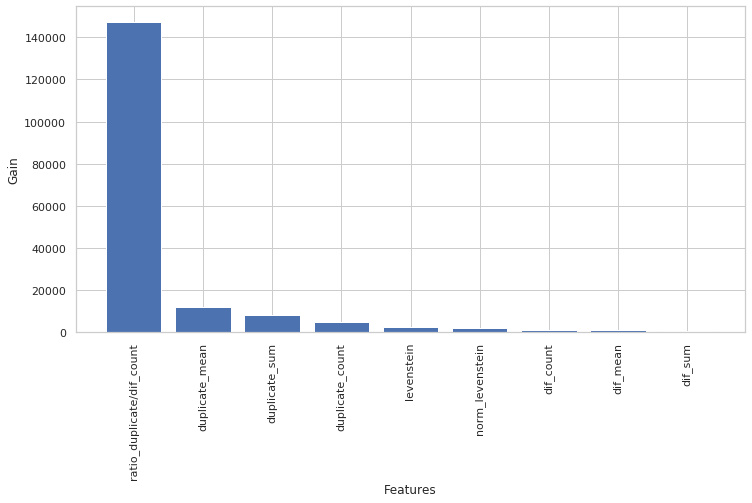

,Features,Gain
8,ratio_duplicate/dif_count,147324.899002
4,duplicate_mean,11875.499512
3,duplicate_sum,8216.401184
2,duplicate_count,5174.549805
0,levenstein,2401.171005
1,norm_levenstein,1861.684952
5,dif_count,1359.109985
7,dif_mean,959.583984
6,dif_sum,791.725983


In [85]:
start = 0
stop = 50
size = (12,6)

tg = table_gain_coef(model,features,start,stop)
gain_hist(tg,size,start,stop)
display(tg)

In [53]:
# baseline_train[baseline_train['length_w1_top_w_min_y']>=0]

# Gradient boosting submission to SIBUR

In [86]:
model = lgb.LGBMClassifier(**params)
model.fit(baseline_train[features].values,
          baseline_train["target"].values)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=1, max_depth=40,
               min_child_samples=5, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=50, reg_alpha=0.0, reg_lambda=0.75, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [87]:
sample_sub = pd.read_csv('sample_submission.csv', index_col="pair_id")

sample_sub['is_duplicate'] = (model.predict_proba(
    baseline_test[features].values)[:, 1] > probability_level).astype(np.int)

In [88]:
sample_sub.to_csv('baseline_submission.csv')

# SCORE (f1 on test samples): 0.4441